In [1]:
import sys
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


import tensorflow as tf
from tensorflow.keras.models import model_from_json
from model.model_unet import unet

from model.model import Model

%load_ext autoreload
%autoreload 2

2026-02-19 01:30:35.751956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 01:30:35.809213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 01:30:36.645341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


In [2]:
artifacts_dir = "data"

In [3]:
def high_freq_mae(y_true, y_pred):
    frequencies = tf.range(512, dtype=tf.float32)
    
    weights = 1.0 + (frequencies / 512.0) * 4.0  
    
    weights = tf.reshape(weights, (1, 512, 1, 1)) 
    
    mae = tf.abs(y_true - y_pred)
    weighted_mae = mae * weights
    
    return tf.reduce_mean(weighted_mae)

In [4]:
with open(f"{artifacts_dir}/mod_unet_last_weights_v16.json", "r") as f:
    model = model_from_json(f.read(), custom_objects={'high_freq_mae': high_freq_mae})
    
# model = unet(input_size=(512, 512, 1))

# model.compile(optimizer='adam', loss=high_freq_mae, metrics=['mae'])

model.load_weights(f"{artifacts_dir}/mod_unet_best.weights.h5")


2026-02-19 01:30:37.722029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/misha/repo/Cassette-denoising/venv_tf2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
denoiser = Model(
    model=model,
    sample_rate=44100,
    min_duration=1.0,
    n_fft=1023,
    hop_length=512,
    chunk_length=512
)

In [6]:
# output_file = "OB_pred.wav"
# input_file = "Object Permanence_noisy.wav"
# output_file = "ELO_1_pred.wav"
# input_file = "ELO_1_raw.wav"
output_file = "DS_pred.wav"
input_file = "DS_smol.wav"
# input_file = "pure_noise.wav"
# output_file = "test.wav"
denoiser.predict(artifacts_dir, input_file, output_file, headroom=1)

Stereo


2026-02-19 01:30:39.420711: I external/local_xla/xla/service/service.cc:163] XLA service 0x738dd000e590 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-02-19 01:30:39.420741: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-02-19 01:30:39.480499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771461039.632566  260030 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Denoised and saved as DS_pred.wav


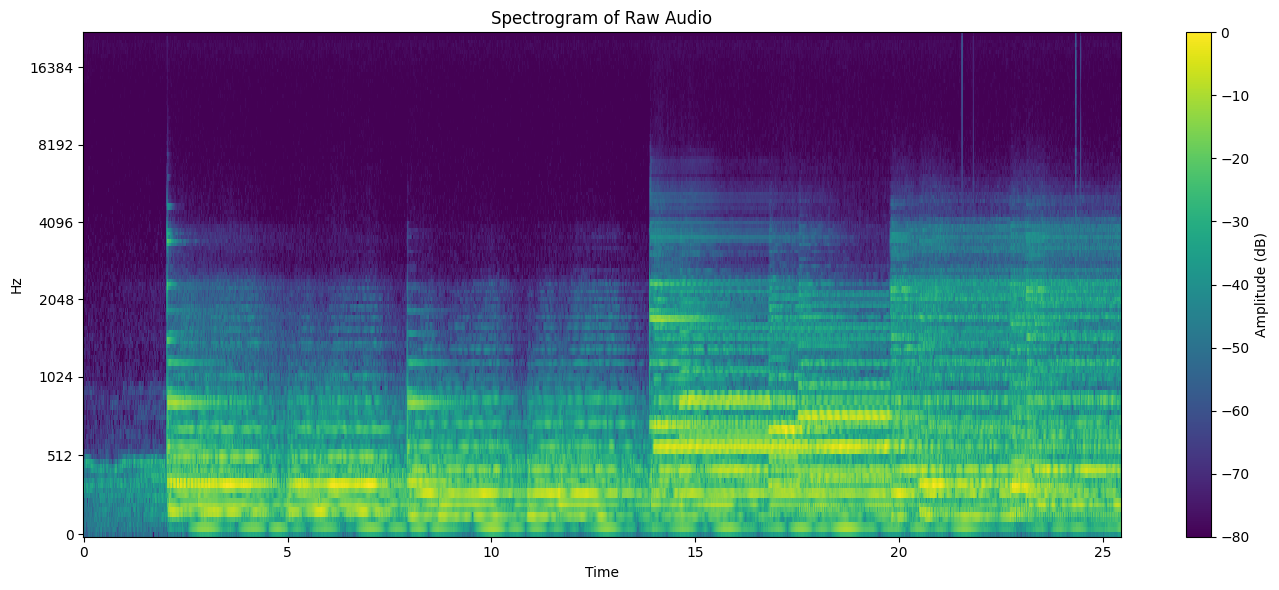

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_path = f"{artifacts_dir}/{input_file}"
y, sr = librosa.load(audio_path, sr=None)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Spectrogram of Raw Audio')
plt.tight_layout()
plt.show()

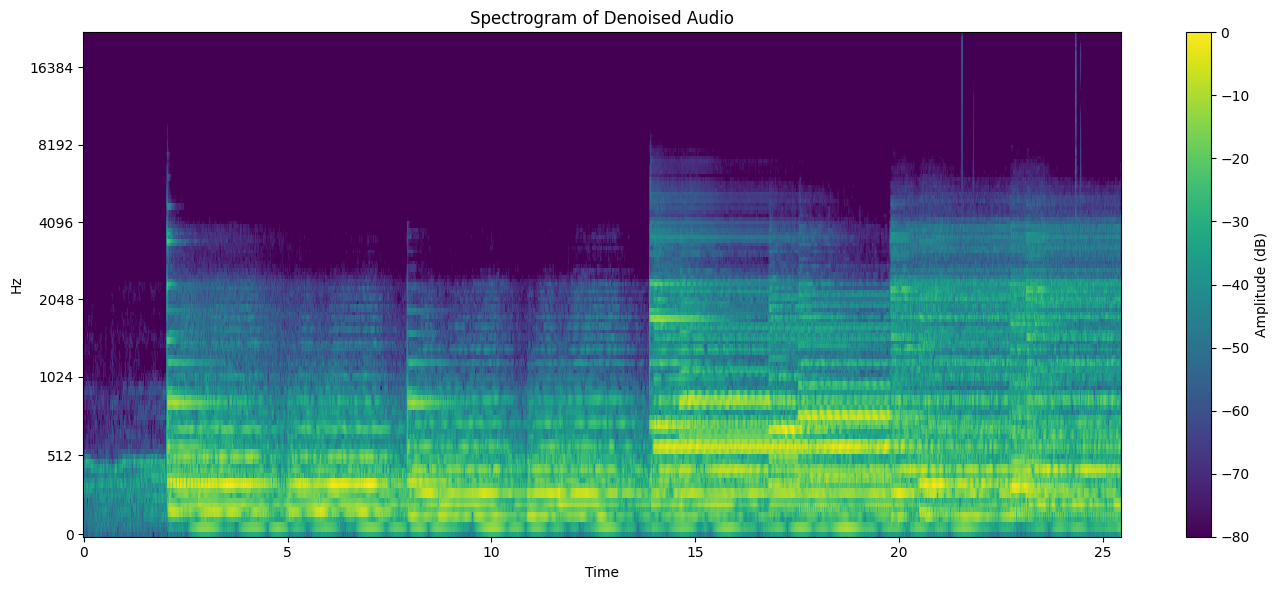

In [8]:
audio_path = f"{artifacts_dir}/{output_file}"
y, sr = librosa.load(audio_path, sr=None)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Spectrogram of Denoised Audio')
plt.tight_layout()
plt.show()